# Magnetic Resonance Imaging

In [15]:
from IPython.core.display import HTML, Markdown, display

import numpy.random as npr
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

class Caption:
    def __init__(self, fig_no, text, c_type='f'):
        self.fig_no = fig_no
        self.text = text
        if c_type=='t':
            self.c_type = 'Table'
        else:
            self.c_type = 'Figure'
    
    def _repr_html_(self):
        return f"<div class=\"alert alert-info\" role=\"alert\"><b>{ self.c_type } { self.fig_no }</b>. { self.text }</div>"

This chapter authored by Shannon Tubridy and [Todd M. Gureckis](http://gureckislab.org/~gureckis) and is released under the [license](/LICENSE.html) for the book. Some materials courtesy of Luke Chang's [Introduction to fMRI Data Analysis](https://dartbrains.org/intro.html).

<img src="../../images/brain_mapping.svg" width="500">

## Introduction

In this chapter we will turn to an introduction to neuroimaging data and specifically to functional magnetic resonance imaging (fMRI). 

Functional MRI is an important tool in contemporary psychological research. The development of MRI scanners that can take advantage of nuclear magnetic resonance to peer inside the human body as it lives and acts is a staggering achievement of human ingenuity, involving decades of work from physicists, engineers, radiologists, neuroscientists, and statisticians.

Although we will spend some time in this section learning about how MRI scanners work and the physiological basis of the Blood Oxygenation Level Depending (BOLD) signal that is usually measured in fMRI experiments, our primary focus will be on applying and what we have learned in previous chapters to a new kind of data. 

A psychologist or cognitive neuroscientist considering an fMRI experiment is faced with a task that is becoming familiar to us: what kinds of questions can be asked with these data and by what techniques can we obtain satisfactory answers?  Building on previous chapters we will find ourselves with large amounts of data. 

Functional MRI measures the signal level from thousands of locations in the brain at repeating times throughout the course of an experiment and our goal is to understand how that signal relates to cognitive and perceptual processing. At the core of our endeavor is the goal of understanding or explaining how a measured outcome -- the signal change over time -- is related to known aspects of the experiment like the timing of stimulus presentation or the observed behavior of a participant.

To achieve this goal we can turn to a familiar friend: regression.

In previous chapters we learned how to quantify the relationship (the *correlation* or *covariation*) between two sets of observations. We also learned how to conduct a regression analysis to assess whether a *predictor* variable like amount of sleep each night could explain the variation in another variable like the amount of grumpiness each day. Doing this involved finding the best values for $B_1$ and $B_0$ so that we could minimize the residual error $\epsilon$ in the regression equation:

$$
Y = b_1 X + b_0 + \epsilon
$$

where $Y$ was a vector of outcome measurements (grumpiness) and $X$ was a vector of possible predictor values (amount of sleep). 

The *best fitting line* reflects the relationship between $X$ and $Y$ and the optimal values of $b_1$ and $b_0$ for a particular regression model (i.e., for a particular set of input and output measurements) are those values that when combined with the values in $X$ produce a set of predicted data values $\hat{Y}_i$ whose summed difference from the true values in $y$ is minimized.

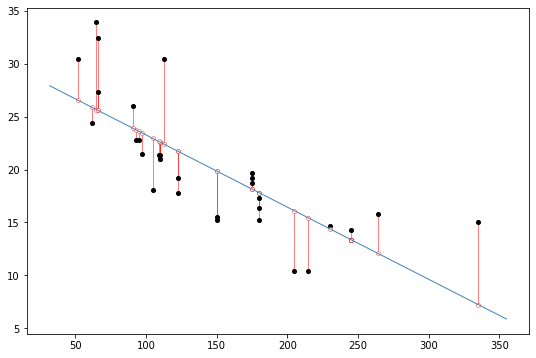

In [16]:
import statsmodels.formula.api as smf
import seaborn as sns

mtcars_df = pd.read_csv('http://gureckislab.org/courses/fall19/labincp/data/mtcars.csv', sep = ',', header='infer')

# fit a linear regression to the mpg column given hp
lr = smf.ols(formula="mpg ~ hp", data=mtcars_df)
fit = lr.fit() # fit
params, pred, resid = fit.params, fit.fittedvalues, fit.resid
#display(fit.summary())

fig, ax = plt.subplots(figsize=(9,6))

x1 = np.linspace(mtcars_df.hp.min()-20, mtcars_df.hp.max()+20,400)
y1 = params['hp']*x1+params['Intercept']

ax.plot(mtcars_df.hp, mtcars_df.mpg,'ko',markersize=4)
ax.plot(mtcars_df.hp, mtcars_df.mpg-resid,'o',markersize=4,markeredgecolor='r', markeredgewidth=.4, markerfacecolor='white')


ax.plot(x1,y1,'-',color='steelblue',linewidth=1)

ax.vlines(mtcars_df.hp, mtcars_df.mpg, mtcars_df.mpg-resid,'r',linewidth=0.5)
plt.show()

display(Caption(1.0, "Black dots represent data points. The blue line is the best fit regression line. The white dots repesent the predicted location of each black dot. The red lines show the error between each black dot and the regression line. The blue line is the best fit line because it minimizes the error shown by the red lines."))


We will use the same approach to understanding fMRI data: we identify factors such as which stimuli were being presented at different points in time that we believe might impact the measured fMRI signal for some parts of the brain. 

We then use the timing of stimulus presentation as our predictor, $X$, and conduct a regression analysis *for each part of the brain*, putting the timecourse of activation for that region into $Y$.



<img src="../../images/mri_regression_overview.svg" width="500">

By assessing which parts of the brain are well explained by the "model" of the response specified by the regression we can then make inferences about how different parts of the brain are related to different kinds of perception and cognition. 

From there we can make beautiful maps like in the figure above that shows *voxels*, or 3D pixels, located in the primary visual cortex of the brain whose timeseries of BOLD signal activation is significantly related our cognitive or perceptual predictor which in this case is the presence or absence of visual stimulation.

There are a number of steps to go through before we get to that point, but at the core of our approach are many of same tools we have seen already. 

Let's go!

## MRI physics and the physiological basis of the BOLD signal

We could spend a whole semester (or all of graduate school, or a whole career!) acquiring a deep understanding of the physics underlying MRI. 

In this class we are primarily concerned with learning about concepts and tools that are commonly used to understand cognitive psychological questions so we will spend the bulk of our time in this unit focused on what to do once we have fMRI data, but there is a wealth of information available for people interested in other aspects of the MRI signal and how it is measured.

In particular there are excellent videos from Tor Wager and Martin Lindquist's Principles of fMRI Coursera class. 

- [Basic MRI Physics](https://www.youtube.com/watch?v=XsDXxgjEJVY)

- [fMRI Signal and BOLD Physiology](https://www.youtube.com/watch?v=jG2WQpgpnMs)

Nonetheless, let's introduce some key ideas around the workings of MRI scanners in general and the BOLD signal, which is the basis for functional MRI, in particular.

<img src="../../images/scanner_equipment.png" width="500">

Obtaining MRI images requires a dedicated MRI center filled with equipment centered around the MRI scanner itself. The basic procedure is to put a person inside of a big magnet where the protons in their body align with the magnetic field, apply energy in the form of radio waves which is absorbed by specific parts of the body, and then measure that energy as it is released from the system.

<img src="../../images/scanner_schematic.png" width="500">

You will find more information in the lectures linked above, but at the core of MRI scanning is nuclear magnetic resonance ([NMR](https://www.sciencedirect.com/science/article/pii/B9780123848628000042)). 

The key insight is that when some object (like a brain) is in a strong magnetic field, the protons in that material tend to align themselves with the orientation of the magnetic field. In the image below the strong magnetic field (corresponding to the tube in the MRI scanner) is in the $z$ direction and the red arrow indicates the "net magnetization" pointing in this direction which can be thought of as reflecting the overall direction of magnetic alignment for the billions of atomic nuclei in that area.

By introducing a pulse of radio frequency energy at a specific, carefully chosen frequency, the MRI scanner pushes some number of atoms out of alignment with the primary magnetic field, moving the net magnetization out of alignment with the $z$ axis.



<img src="../../images/RF_pulse.png" width="500">

After the RF pulse is turned off, the out-of-alignment protons are pointing into the $xy$ plane, but as they release absorbed energy, they move back into aligment with the primary magnetic field pointing in the $z$ direction. Measuring this chacteristic move back into alignment with the primary magnetic field is the basis of MRI measurements.

A key to MRI is the knowledge that different kinds of atomic nuclei have different *resonant frequencies*. This knowledge guides the choise of RF pulse frequency described above, allowing researchers to target different kinds of materials. The resonant frequency is also known as the [Larmor frequency](https://www.mr-tip.com/serv1.php?type=db1&dbs=Larmor%20Frequency) and is given by the Larmor equation $f_0 = \gamma B_0$ with $\gamma$ corresponding to the gyromagnetic ratio and $B_0$ the strength of the magnetic field. The gyromagnetic ratio is different for different kinds of atomic nuclei (e.g. Hydrogen vs Helium vs Carbon) and these values are known.

Combining the known gyromagnetic ratio $\gamma$ with the known magnet strength $B_0$, a resonant frequency can be chosen to target a specific kind of atom. By introducing energy into the system at that frequency and then measuring the release of that energy an MRI scanner can record how much of that kind of atom was present at the time of the measurement. This procedure is repeated for many locations in the 3D space occupied by the object being scanned, resulting in a 3D image where each *voxel*, or 3D pixel, has an intensity corresponding to the measurement just described.

Although we will be talking about MRI in the context of imaging the structure and activity in the human brain, the principles of NMR leveraged by MRI can be used to image many kinds of material. Many people have MRI scans taken of other parts of their body in a medical context in order to detect damage to soft tissue. Other people do things like make cool pictures of the inside of fruits (image from the [Inside Insides](http://insideinsides.blogspot.com/) blog).

Here is an MRI scan of a pear.

<img src="http://1.bp.blogspot.com/-hss278rTMjk/VZK6ddHIIlI/AAAAAAAArlI/bwgnqZucNVI/s1600/PearHIRES.gif" width="400">

Or maybe you prefer papaya?

<img src="../../images/papayafmri.gif" width="400">

## Structural and functional imaging of the human brain

Fruits are interesting and it's fun to see them in the scanner, but you're in this class because you are (hopefully) interested in how human cognition and perception, so let's talk about the brain.

There are two primary kinds of MR images that make up the bulk of data collected in human neuroimaging. This figure shows a structural and a functional image of the same brain.

<img src="../../images/struct_func.svg" width="500">

***Structural*** images give a static, meaning no change over time, image that is tuned to detect differences between gray matter and white matter in the brain. These structural images do not give any information about what was happening at each location in the brain but they provide high spatial resolution that enables analysis of the anatomy of that brain.

***Functional*** images are the data acquired in ***f***MRI. Functional MRI is tuned to detect changes in the Blood Oxygenation Level Dependent (BOLD) signal (discussed below). The BOLD signal derives from changes in the oxygen level of blood that are related to neural activity. Although the spatial resolution of fMRI is much worse than structural MRI, fMRI measures a signal that changes from moment to moment as neural activity waxes and wanes and so it provides an indirect measurement of neural activity over time.

<img src="../../images/brain_basics.svg" width="500">


The data obtained from these two types of scans differ in several ways. Structural MRI results in a single ***volume*** which is the 3D box corresponding to the area scanned by the MRI machine. This volume is composed of individual ***voxels*** which are like three-dimensional pixels (the green and blue boxes in the image above). Voxels are the basic spatial unit of measurement in MRI and in structural MRI like the image above they are usually around 1mm x 1mm x 1mm. The MRI machine measures one number per voxel, and in structural MRI there is a single volume because we do not expect the anatomy to change across the timescale of the scanning session. This results in a three-dimensional dataset.

Functional MRI data also contains volumes composed of individual voxels. In fMRI these voxels tend to be in the size range of 3mm x 3mm x 3mm, but unlike structural MRI we get a measurement from each voxel at each timestep of the experiment. The unit of time in MRI is a ***TR*** (time to repetition) which is the time it takes to make a single measurement from each voxel in the volume. In fMRI this is usually in the range of 1 to 3 seconds. 

In contrast to structural MRI which is measuring signal that distinguishes different tissue types from each other, fMRI is measuring the BOLD signal which changes at each moment in time in response to nearby neural activity. This means an fMRI dataset is four-dimensional, containing a volume of $N$ voxels measured at each of $T$ timepoints. Then, for each voxel (corresponding to an $x,y,z$ coordinate in the 3D volume) there is a timeseries of BOLD activation measured during the course of the experiment.


## The BOLD signal

The development of Blood Oxygination Level Depending (BOLD) fMRI, based on work by Seiji Ogawa, was a major advance in MRI scanning. The key to BOLD imaging is the insight that the magnetic properties of blood change depending on the level of oxygen in the blood and that the level of oxygen in a given quantity of blood is related to metabolic activity. 

For brain imaging this enables an indirect measurement of neural activity because neural activity is *very* energy dependent, requiring ATP for ion transport channels at the synapse level. Blood vessels innervate the brain in order to support these energy needs by delivering oxygen to facililtate ATP production. Neural activity causes consumption of oxygen from the blood in the immediate area of the active neurons. This causes a change to the magnetic properties of that blood. This is followed by an increase of oxygenated blood flowing into the area, leading to further changes in the magnetic properties of the blood. These changing mangetic properties of blood associated with neural activity are the changes in BOLD signal we measure over time for each voxel.

<img src="../../images/hemo_bold.svg" width="500">

Although the BOLD signal is an indirect measurement of neural activity -- we aren't measuring neurons themselves -- these magnetic properties of de/oxygenated blood and its' proximity to neural activity is what enables scientists to use fMRI to probe the engagement of different parts of the brain as people engage in cognition and perception.

## A simple visual perception experiment

Let's take a look at an example of how one might conduct an experiment measuring how the brain responds to visual stimulation ([Kwong et al., PNAS, 1992](https://www.pnas.org/content/89/12/5675.long)).

<img src="../../images/BOLD_V1.svg" width="500">

The pattern on the left shows a salient visual stimulus that was presented to the participant. The stimulus presentation alternated with periods of blank screen. 

The center of the figure shows example *slices* through the middle of the 3D BOLD data volume during periods of no visual stimulation ("off") and during the times when the visual pattern was shown ("on"). The brain slices are oriented as if you were looking down at the top of the head, with the front of the head pointing to the top of the image. If you examine the intensity of the voxels near the back of the head (bottom of the slices) you might notice that they are brighter in the "on" periods than during the "off" periods.

Another way to look at the data is to take the activation from one or several voxels and plot the timeseries of activation through the course of the experiment as is shown in the right side of the figure. Overlaid on the timecourse are indications of when the visual stimulation was off and when it was on.

From this figure it is clear that the plotted voxel timecourse seems to have a relationship with the visual stimulation. In particular we can see that when the visual stimulation was on the signal was high and when it was off the signal was low. 

Put another way, it seems like the variation in the timecourse of the visual stimulation is related to the variation of the signal in the voxel timecourse. One might even say that there seems to be some *covariation* in the two timecourses.



## The hemodynamic response function

In the simple visual experiment example we just saw it seems clear that there is a relationship between the visual stimulation ("on" or "off") and the level of signal in voxels from the visual cortex. But if you look closely at the figure you might also notice that there is a delay between the onset of a visual stimulus (like at timepoint 60) and the rise in signal intensity measured in the brain. This delay looks to be on the order of seconds, but we know that neurons in the visual cortex respond to visual stimulation within milliseconds of it appearing on the retina.

This lag between stimulus onset (and presumed neural response to the stimulus) and the measured BOLD signal results from what is known as the Hemodynamic Response Function (HRF).

<img src="../../images/stim_bold_lag.png" width=500>

The HRF is the timecourse of BOLD activation in response to a brief neural event. It was originally derived empirically as the measured BOLD response in visual cortex to a brief *impulse* of stimulation: researchers flashed extremely brief visual stimulation which is known to lead to action potentials in primary visual cortex (V1) within milliseconds of stimulus onset and this neural activity stops when the visual input stops. By measuring the BOLD response in visual cortex in response to this visual stimulation researchers determined that neural activity leads to BOLD signal that has a characteristic shape and timing.

<img src="../../images/hrf_wiki_plus_labels.svg" width=500>

The interpretation of the HRF is that whenever there is neural activity above some threshold we should expect changes in the BOLD signal to be measurable in that area and this BOLD measurement will follow a characteristic shape, beginning to rise several seconds after the neural activity (stimulus presentation), peaking approximately 4-8 seconds after stimulus onset.

If you look back at the visual stimulation experiment figure and focus on the line indicating "on" for a stimulus and then look at the shape of the rising signal intensity during that period you'll see that it looks similar to our HRF schematic here where the stimulus onset is followed several seconds later by a slow rise to the peak response.

## Putting it together

In this reading we saw an introduction to how MRI images are created, the kinds of signals we can measure from the brain, and how we might begin to relate stimulus presentation to the measured BOLD signal to understand what different brain areas are doing.

But there are thousands of voxels in the brain and we would like a way to quantitatively assess whether their activation can be explained by the experimental protocol. 

The primary way of doing this is using regression, where the timecourse of activation from each voxel is regressed on the timeseries of stimulus presentation (taking into consideration the delay caused by the HRF). 

<img src="../../images/mri_regression_overview.svg" width="500">

This procedure results in a best fitting $b_1$ estimate for each voxel -- indicating how much a change in the $X$ values (stimulus off or on in the visual experiment example) causes a change in the $Y$ values (the activation at each timepoint for a voxel) -- and the sum of the squared residuals telling us how much of that voxel's activation was explained by the best fitting prediction.

We can then generate maps showing which parts of the brain might be related to a cognitive or perceptual task by using the structural MRI image and coloring those voxels for which the regression model provided a good explanation of the data.

In the example here you can see primary visual cortex highlighted on a structural scan oriented so that the person is facing to the right of the screen and their visual cortex is on the left of the screen. The orange color reflects how well the voxel timecourse was fit by the predictor timecourse, and the image is thresholded to only show those voxels for which the regression provided a good fit.

This week in lab we will dive into the details of this procedure, fitting our own regression model to a dataset obtained during an auditory perception experiment.

## Assigned Readings (and viewings)

Watch the "Basic MR Physics" and "fMRI Signal and BOLD Physiology" lectures from Lindquist and Wager's Coursera course (they're about 12 minutes each):

- [Basic MRI Physics](https://www.youtube.com/watch?v=XsDXxgjEJVY)

- [fMRI Signal and BOLD Physiology](https://www.youtube.com/watch?v=jG2WQpgpnMs)


We are going to carry on with what we learned about regression, so please review (or catch up on...) the Regression chapter from this course:

- http://gureckislab.org/courses/fall19/labincp/chapters/06/00-linearregression.html 

When we begin analyzing fMRI data ourselves we will confront the issue of multiple comparisons. 

Briefly, the issue is that when we do a separate regression analysis for each voxel we are doing thousands of statistical comparisons or tests. 

If we consider the conventional statistical signficicance approach where we accept a statistical test as showing a real result if it has less than 5% chance of showing a type 1 error (aka a false positive aka less than 5% chance of being due to chance) we have a problem. If there are 10,000 voxels in the brain, a 5% false positive rate would mean we could expect around 500 voxels to be falsely indentified as related to the $X$ predictor.

During the next part of lab we will consider this issue and ways to overcome it. As a warm up take a look at this short article:

- https://towardsdatascience.com/the-multiple-comparisons-problem-e5573e8b9578

As well as review the "Correlation and Random chance" section in the Correlation chapter from this course:

- http://gureckislab.org/courses/fall19/labincp/chapters/05/00-correlation.html#Correlation-and-Random-chance


